In [1]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import math

# Decoder
인코더 출력과 teacher forcing으로 들어온 이전 토큰들을 받아 다음 토큰 확률을 예측하는 Transformer 디코더를 순차적으로 살펴봅니다.
- Masked Multi-Head Self-Attention (look-ahead mask)
- Encoder-Decoder Multi-Head Attention
- Position-wise FeedForward Network


In [ ]:
# 1️⃣ 디코더 입력 토큰화 + 숫자화
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# teacher forcing: 이전 정답 토큰들을 디코더 입력으로 사용
target_text = "I like coffee in the morning because it helps me wake up and stay focused."
decoder_tokens = tokenizer(target_text, return_tensors="pt")
decoder_input_ids = decoder_tokens["input_ids"]
decoder_target_ids = decoder_input_ids[0]

print("디코더 토큰 목록:", tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
print("디코더 토큰 ID:", decoder_input_ids)
print("디코더 타깃 ID(shifted):", decoder_target_ids)
for t in decoder_input_ids[0]:
    print(f"{t.item()}\t -> {tokenizer.decode([t.item()])}")


TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [3]:
# 2️⃣ 임베딩 (Decoder input embedding)
vocab_size = tokenizer.vocab_size   # 약 30,000개 단어
d_model = 4                         # 논문 기준은 512

decoder_embedding = nn.ModuleDict({
    "token_embedding": nn.Embedding(vocab_size, d_model)
})

print(decoder_embedding.token_embedding)
decoder_X = decoder_embedding.token_embedding(decoder_input_ids)

print("디코더 임베딩 텐서:", decoder_X)
print("디코더 임베딩 크기:", decoder_X.shape)


Embedding(30522, 4)
디코더 임베딩 텐서: tensor([[[ 5.2831e-01,  1.5856e+00, -4.9505e-01, -4.8051e-01],
         [ 5.2831e-01,  1.5856e+00, -4.9505e-01, -4.8051e-01],
         [ 3.8160e-01,  2.0352e+00, -6.7918e-01,  6.3281e-01],
         [ 7.7376e-01,  6.4248e-01, -4.8874e-02,  3.7220e-01],
         [ 4.1509e-01,  7.5659e-01,  2.1251e+00, -1.0968e-01],
         [-4.2912e-01,  2.9536e-01, -9.6217e-01,  1.5685e-01],
         [-1.2461e+00,  1.2405e+00, -1.3655e+00,  4.2600e-01],
         [-1.0331e+00,  1.9600e+00, -6.0087e-01, -4.2490e-01],
         [-4.0424e-01,  2.3017e-01, -2.0536e+00,  1.0506e-01],
         [-3.2468e-02,  8.7252e-01,  1.4477e+00,  1.5222e-01],
         [ 7.5108e-01, -6.6747e-01,  8.7519e-01, -1.7181e+00],
         [-1.3646e+00,  2.4797e-01,  5.3257e-01,  1.3213e+00],
         [ 6.5795e-01, -6.7597e-01,  1.5550e+00,  1.0138e+00],
         [-2.7069e-01,  7.7890e-01, -6.6325e-01, -1.2819e-02],
         [-7.3030e-01, -3.2034e+00,  1.8455e+00, -9.3708e-01],
         [-1.1656e+00, 

# Positional Encoding

$$ PE(pos,2i)=sin(\frac{pos} {10000^{2i/d_{model}}}) $$
$$ PE(pos,2i+1)=cos(\frac{pos} {10000^{2i/d_{model}}}) $$


디코더 Positional Encoding: [[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]
 [-0.95892427  0.28366219  0.04997917  0.99875026]
 [-0.2794155   0.96017029  0.05996401  0.99820054]
 [ 0.6569866   0.75390225  0.06994285  0.997551  ]
 [ 0.98935825 -0.14550003  0.07991469  0.99680171]
 [ 0.41211849 -0.91113026  0.08987855  0.99595273]
 [-0.54402111 -0.83907153  0.09983342  0.99500417]]


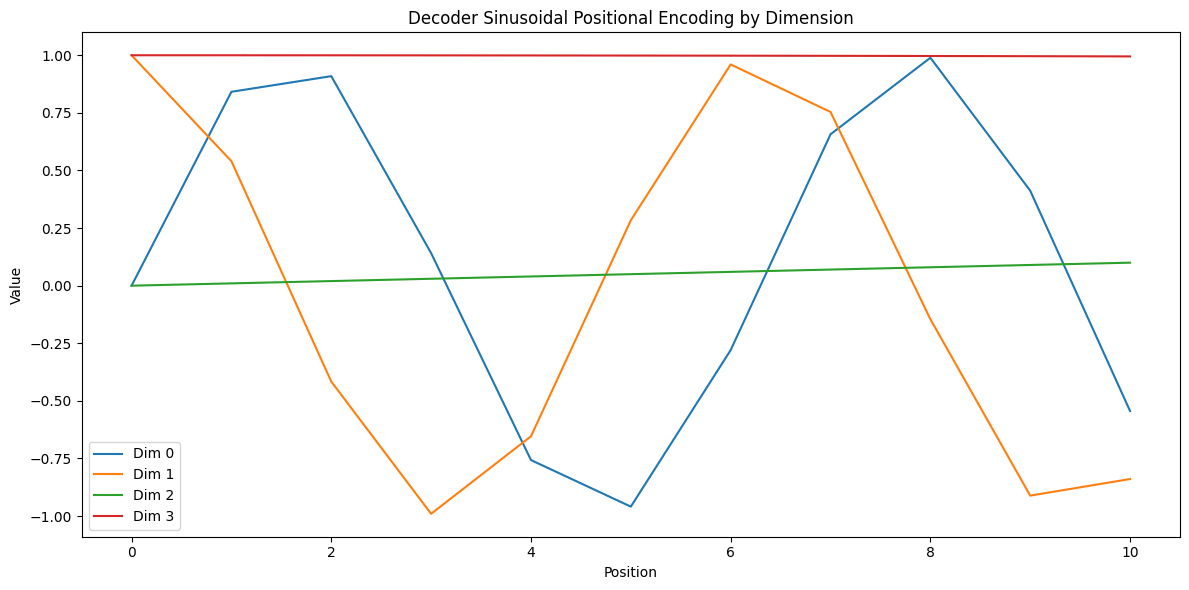

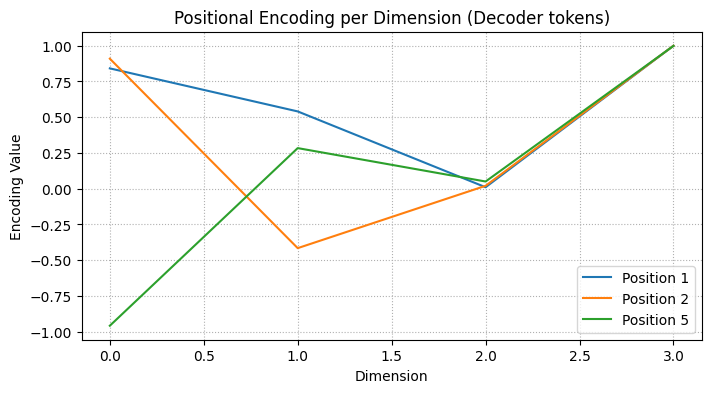

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(max_position, d_model):
    position = np.arange(max_position)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

    pe = np.zeros((max_position, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

decoder_seq_len = decoder_input_ids.size(1)
pe = positional_encoding(decoder_seq_len, d_model)
print("디코더 Positional Encoding:", pe)

plt.figure(figsize=(12, 6))
for d in range(d_model):
    plt.plot(pe[:, d], label=f'Dim {d}')
plt.legend()
plt.title('Decoder Sinusoidal Positional Encoding by Dimension')
plt.xlabel('Position')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

pos_a, pos_b = 1, min(2, decoder_seq_len - 1)
pos_c = min(5, decoder_seq_len - 1)
plt.figure(figsize=(8, 4))
plt.plot(pe[pos_a], label=f'Position {pos_a}')
plt.plot(pe[pos_b], label=f'Position {pos_b}')
plt.plot(pe[pos_c], label=f'Position {pos_c}')
plt.title('Positional Encoding per Dimension (Decoder tokens)')
plt.xlabel('Dimension')
plt.ylabel('Encoding Value')
plt.legend()
plt.grid(True, linestyle=":")
plt.show()


## Positional Encoding + Embedding


In [5]:
pe_tensor = torch.tensor(pe, dtype=decoder_X.dtype)
print(decoder_X.shape, pe_tensor.shape)
pe_tensor.unsqueeze_(0)
print(decoder_X.shape, pe_tensor.shape)
decoder_X_input = decoder_X + pe_tensor
print("Positional Encoding이 더해진 디코더 입력:", decoder_X_input.shape)

torch.Size([1, 11, 4]) torch.Size([11, 4])
torch.Size([1, 11, 4]) torch.Size([1, 11, 4])
Positional Encoding이 더해진 디코더 입력: torch.Size([1, 11, 4])


## Masked Multi-Head Self-Attention
디코더는 미래 토큰을 보지 못하도록 상삼각 마스크(look-ahead mask)를 적용한 상태에서 멀티-헤드 어텐션을 수행합니다.


In [6]:
num_heads = 2  # d_model은 num_heads로 나누어 떨어져야 합니다.
head_dim = d_model // num_heads

self_attention = nn.ModuleDict({
    "w_q": nn.Linear(d_model, d_model),
    "w_k": nn.Linear(d_model, d_model),
    "w_v": nn.Linear(d_model, d_model),
    "w_o": nn.Linear(d_model, d_model)
})

batch_size, seq_len, _ = decoder_X_input.shape
Q = self_attention["w_q"](decoder_X_input).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
K = self_attention["w_k"](decoder_X_input).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
V = self_attention["w_v"](decoder_X_input).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)

scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(head_dim)
look_ahead_mask = torch.triu(torch.ones(seq_len, seq_len, device=scores.device), diagonal=1).bool()
look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(0)
scores = scores.masked_fill(look_ahead_mask, float('-inf'))

self_attn_weights = torch.softmax(scores, dim=-1)
self_attn_output = torch.matmul(self_attn_weights, V)

self_attn_output = self_attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
self_attn_output = self_attention["w_o"](self_attn_output)
print("Masked Self-Attention 출력 형태:", self_attn_output.shape)


Masked Self-Attention 출력 형태: torch.Size([1, 11, 4])


## Add & Norm
Residual connection과 LayerNorm으로 서브레이어 출력을 안정화합니다.


In [7]:
def add_norm(x, sublayer_out, d_model, dropout_rate=0.1):
    norm = nn.LayerNorm(d_model)
    dropout = nn.Dropout(dropout_rate)
    return norm(x + dropout(sublayer_out))

decoder_self_residual = add_norm(decoder_X_input, self_attn_output, d_model)
print("Self-Attention Add & Norm 결과 형태:", decoder_self_residual.shape)


Self-Attention Add & Norm 결과 형태: torch.Size([1, 11, 4])


## Encoder-Decoder Attention
인코더 출력(`memory`)을 Key/Value로 사용해 입력 문장과 디코더 현재 상태를 연결합니다.


In [8]:
encoder_seq_len = 6
encoder_memory = torch.randn(batch_size, encoder_seq_len, d_model)  # 실제로는 인코더 출력이 들어옵니다.

cross_attention = nn.ModuleDict({
    "w_q": nn.Linear(d_model, d_model),
    "w_k": nn.Linear(d_model, d_model),
    "w_v": nn.Linear(d_model, d_model),
    "w_o": nn.Linear(d_model, d_model)
})

Q_cross = cross_attention["w_q"](decoder_self_residual).view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
K_cross = cross_attention["w_k"](encoder_memory).view(batch_size, encoder_seq_len, num_heads, head_dim).transpose(1, 2)
V_cross = cross_attention["w_v"](encoder_memory).view(batch_size, encoder_seq_len, num_heads, head_dim).transpose(1, 2)

cross_scores = torch.matmul(Q_cross, K_cross.transpose(-2, -1)) / math.sqrt(head_dim)
encoder_padding_mask = torch.ones(encoder_seq_len, device=cross_scores.device, dtype=torch.bool)
encoder_padding_mask[-1] = False  # 패딩 토큰 예시
encoder_padding_mask = encoder_padding_mask.view(1, 1, 1, encoder_seq_len)
cross_scores = cross_scores.masked_fill(~encoder_padding_mask, float('-inf'))

cross_attn_weights = torch.softmax(cross_scores, dim=-1)
cross_attn_output = torch.matmul(cross_attn_weights, V_cross)
cross_attn_output = cross_attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
cross_attn_output = cross_attention["w_o"](cross_attn_output)

decoder_cross_residual = add_norm(decoder_self_residual, cross_attn_output, d_model)
print("Encoder-Decoder Attention Add & Norm 결과 형태:", decoder_cross_residual.shape)


Encoder-Decoder Attention Add & Norm 결과 형태: torch.Size([1, 11, 4])


## FeedForward Network
각 토큰별로 독립적인 2층 완전연결 네트워크로 표현력을 확장합니다.


In [9]:
dropout_rate = 0.1
d_ff = 4 * d_model

decoder_ffn = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(d_ff, d_model),
)

ffn_output = decoder_ffn(decoder_cross_residual)
decoder_output = add_norm(decoder_cross_residual, ffn_output, d_model)
print("FeedForward Add & Norm 결과 형태:", decoder_output.shape)


FeedForward Add & Norm 결과 형태: torch.Size([1, 11, 4])


## Output Projection
최종적으로 vocab 차원으로 사상한 뒤 softmax로 다음 토큰 확률을 계산합니다.


In [10]:
projection = nn.Linear(d_model, vocab_size)
logits = projection(decoder_output)
print("로짓 텐서 shape:", logits.shape)

next_token_probs = torch.softmax(logits[:, -1], dim=-1)
topk = torch.topk(next_token_probs, k=5)
for idx, prob in zip(topk.indices[0], topk.values[0]):
    print(f"{idx.item():5d} -> {tokenizer.decode([idx.item()])} (prob={prob.item():.4f})")


로짓 텐서 shape: torch.Size([1, 11, 30522])
 5758 -> memories (prob=0.0002)
11925 -> contacted (prob=0.0002)
12861 -> 1809 (prob=0.0002)
 4858 -> finds (prob=0.0002)
10628 -> curiosity (prob=0.0002)
